Training data shape: (1821, 5)

First few rows of training data:
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

Class distribution:
healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64


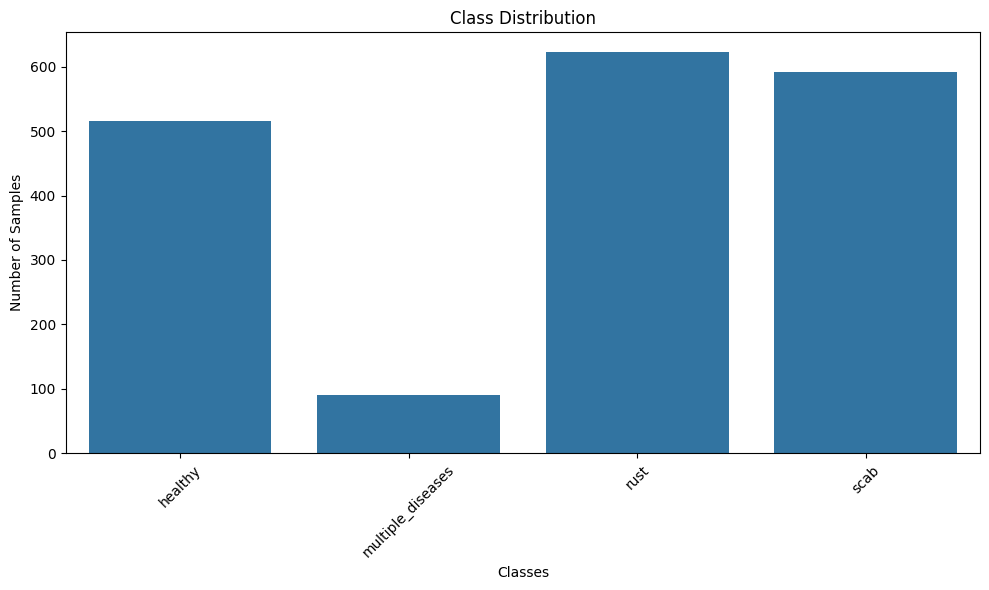

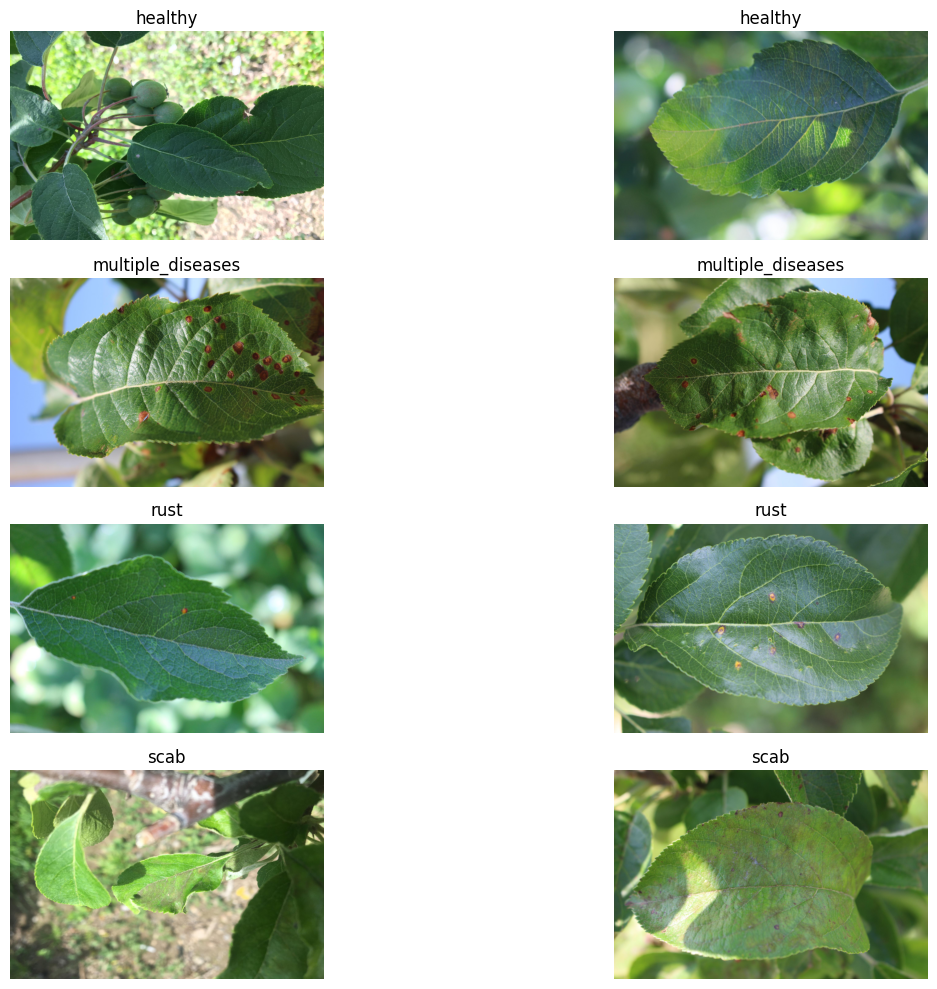

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Explore the training data
print("Training data shape:", train_df.shape)
print("\nFirst few rows of training data:")
print(train_df.head())

# Count samples per class
class_counts = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].sum()
print("\nClass distribution:")
print(class_counts)

# Check for class imbalance
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize sample images from each class
def show_images(df, img_dir, num_samples=2):
    class_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(class_cols):
        # Get samples of this class
        class_samples = df[df[class_name] == 1]['image_id'].values
        selected_samples = np.random.choice(class_samples, num_samples, replace=False)
        for j, img_id in enumerate(selected_samples):
            img_path = 'images' + img_id + '.jpg'
            img = Image.open(img_path)
            plt.subplot(len(class_cols), num_samples, i*num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Make sure to use the correct path where your images are stored
show_images(train_df, 'images', num_samples=2)

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define the base directory
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/plant-pathology'
CSV_PATH = os.path.join(BASE_DIR, 'train.csv')
IMG_DIR = os.path.join(BASE_DIR, 'images')

class AppleLeafDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.class_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.data_frame.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_id)

        # Handle both train and test cases (test won't have .jpg extension in csv)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_id}.jpg")

        image = Image.open(img_path).convert('RGB')

        # For test data, we won't have labels
        if len(self.data_frame.columns) > 1:
            labels = self.data_frame.iloc[idx, 1:5].values.astype('float32')
        else:
            labels = torch.zeros(4)  # Placeholder for test data

        if self.transform:
            image = self.transform(image)

        return image, labels

# Define transforms
def get_transforms(phase):
    if phase == 'train':
        return transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:  # validation or test
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# Set train-validation split
from sklearn.model_selection import train_test_split

train_df = pd.read_csv(CSV_PATH)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, random_state=42,
    stratify=train_df[['healthy', 'multiple_diseases', 'rust', 'scab']]
)

# Save temporary CSV files for train and validation
TRAIN_TEMP_CSV = os.path.join(BASE_DIR, 'train_temp.csv')
VAL_TEMP_CSV = os.path.join(BASE_DIR, 'val_temp.csv')

train_df.to_csv(TRAIN_TEMP_CSV, index=False)
val_df.to_csv(VAL_TEMP_CSV, index=False)

# Create datasets
train_dataset = AppleLeafDataset(
    csv_file=TRAIN_TEMP_CSV,
    img_dir=IMG_DIR,
    transform=get_transforms('train')
)

val_dataset = AppleLeafDataset(
    csv_file=VAL_TEMP_CSV,
    img_dir=IMG_DIR,
    transform=get_transforms('val')
)

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=2  # Reduced num_workers for Colab
)

val_loader = DataLoader(
    val_dataset, batch_size=16, shuffle=False, num_workers=2  # Reduced num_workers for Colab
)

# Check dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Verify a batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Training dataset size: 1456
Validation dataset size: 365
Batch shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16, 4])


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F

class SEResNeXt50Model(nn.Module):
    def __init__(self, pretrained=True, num_classes=4):
        super(SEResNeXt50Model, self).__init__()
        # Load pre-trained SE-ResNeXt50 model
        self.model = models.resnext50_32x4d(pretrained=pretrained)

        # Add Squeeze-and-Excitation blocks
        # Note: In torchvision >= 0.13, resnext50 already has SE blocks
        # If using an older version, you might need to implement SE blocks manually

        # Modify the final layer for multi-label classification
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        output = self.model(x)
        return output

# Initialize the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SEResNeXt50Model(pretrained=True)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Appropriate for multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

Using device: cuda:0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_val_loss = float('inf')
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)

                # For computing metrics
                preds = torch.sigmoid(outputs) >= 0.5
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        epoch_val_loss = running_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)

        # Compute validation accuracy
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        accuracy = np.mean((all_preds == all_labels).astype(np.float32))
        history['val_accuracy'].append(accuracy)

        print(f'Train Loss: {epoch_train_loss:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}')
        print(f'Val Accuracy: {accuracy:.4f}')

        # Learning rate scheduler step
        scheduler.step(epoch_val_loss)

        # Save best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), os.path.join(BASE_DIR, 'best_model.pth'))
            print('Model saved!')

        print()

    return model, history

Epoch 1/15
----------
Train Loss: 0.2861
Val Loss: 0.1065
Val Accuracy: 0.9651
Model saved!

Epoch 2/15
----------
Train Loss: 0.2063
Val Loss: 0.1016
Val Accuracy: 0.9610
Model saved!

Epoch 3/15
----------
Train Loss: 0.1824
Val Loss: 0.0846
Val Accuracy: 0.9733
Model saved!

Epoch 4/15
----------
Train Loss: 0.1683
Val Loss: 0.1090
Val Accuracy: 0.9630

Epoch 5/15
----------
Train Loss: 0.1501
Val Loss: 0.0957
Val Accuracy: 0.9616

Epoch 6/15
----------
Train Loss: 0.1509
Val Loss: 0.0772
Val Accuracy: 0.9699
Model saved!

Epoch 7/15
----------
Train Loss: 0.1419
Val Loss: 0.0718
Val Accuracy: 0.9726
Model saved!

Epoch 8/15
----------
Train Loss: 0.1479
Val Loss: 0.0667
Val Accuracy: 0.9801
Model saved!

Epoch 9/15
----------
Train Loss: 0.1374
Val Loss: 0.0812
Val Accuracy: 0.9774

Epoch 10/15
----------
Train Loss: 0.1384
Val Loss: 0.0926
Val Accuracy: 0.9664

Epoch 11/15
----------
Train Loss: 0.1516
Val Loss: 0.0814
Val Accuracy: 0.9671

Epoch 12/15
----------
Train Loss: 0.119

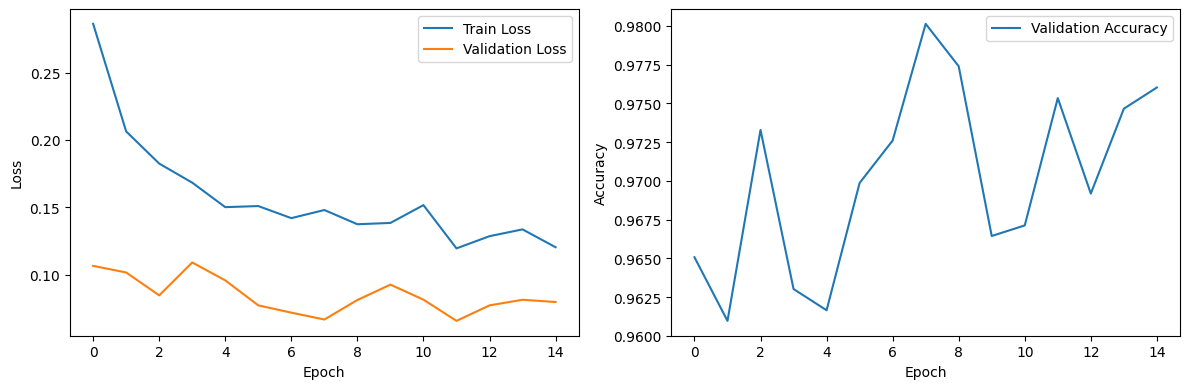

<All keys matched successfully>

In [ ]:
# Start training
num_epochs = 15
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Load the best model for evaluation
model.load_state_dict(torch.load(os.path.join(BASE_DIR, 'best_model.pth')))

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) >= 0.5
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Calculate metrics
    accuracy = np.mean((all_preds == all_labels).astype(np.float32))

    # Calculate F1, precision, and recall for each class
    f1_scores = []
    precision_scores = []
    recall_scores = []

    for i in range(4):
        f1 = f1_score(all_labels[:, i], all_preds[:, i])
        precision = precision_score(all_labels[:, i], all_preds[:, i])
        recall = recall_score(all_labels[:, i], all_preds[:, i])

        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

    # Print results
    classes = ['healthy', 'multiple_diseases', 'rust', 'scab']
    print(f'Overall Accuracy: {accuracy:.4f}')

    for i, class_name in enumerate(classes):
        print(f'{class_name} - F1: {f1_scores[i]:.4f}, Precision: {precision_scores[i]:.4f}, Recall: {recall_scores[i]:.4f}')

    return accuracy, f1_scores, precision_scores, recall_scores

# Evaluate on validation set
accuracy, f1_scores, precision_scores, recall_scores = evaluate_model(model, val_loader)

Overall Accuracy: 0.9753
healthy - F1: 0.9612, Precision: 0.9612, Recall: 0.9612
multiple_diseases - F1: 0.6154, Precision: 0.5714, Recall: 0.6667
rust - F1: 0.9841, Precision: 0.9764, Recall: 0.9920
scab - F1: 0.9614, Precision: 0.9825, Recall: 0.9412


In [ ]:
def predict_test(model, test_csv, img_dir):
    # Load test data
    test_df = pd.read_csv(test_csv)

    # Create test dataset
    test_transform = get_transforms('val')  # Use validation transforms for test

    test_dataset = AppleLeafDataset(
        csv_file=test_csv,
        img_dir=img_dir,
        transform=test_transform
    )

    test_loader = DataLoader(
        test_dataset, batch_size=16, shuffle=False, num_workers=2
    )

    # Make predictions
    model.eval()
    all_preds = []
    all_ids = []

    with torch.no_grad():
        for i, (inputs, _) in enumerate(test_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu().numpy()

            # Get corresponding image IDs
            batch_ids = test_df.iloc[i*test_loader.batch_size:(i+1)*test_loader.batch_size, 0].values

            all_preds.append(preds)
            all_ids.extend(batch_ids)

    all_preds = np.vstack(all_preds)

    # Create submission dataframe
    submission_df = pd.DataFrame({
        'image_id': all_ids,
        'healthy': all_preds[:, 0],
        'multiple_diseases': all_preds[:, 1],
        'rust': all_preds[:, 2],
        'scab': all_preds[:, 3]
    })

    # Save submission
    submission_path = os.path.join(BASE_DIR, 'submission.csv')
    submission_df.to_csv(submission_path, index=False)
    print(f'Submission saved to {submission_path}')

    return submission_df

# Generate predictions for test set
test_csv = os.path.join(BASE_DIR, 'test.csv')
submission_df = predict_test(model, test_csv, IMG_DIR)

Submission saved to /content/drive/MyDrive/Colab Notebooks/plant-pathology/submission.csv
